# PittPACC NUISANCE3 Demo

## Reading event vectors

NUISANCE3 uses 'input handlers' in a similar way to NUISANCE2, but with much stricter de-coupling of the input converter logic from the rest of the framework. An input handler's job is to read some vector and return an event stream in NuHepMC format.

First, lets generate a small NuWro file using shell magic and some NUISANCE2 helper scripts

In [1]:
%%bash
if [ ! -e NuWro.numu.BNB_uBooNE.100k.root ]; then
    mkdir -p nuwrogen
    cd nuwrogen
    nuis gen NuWro -E MicroBooNE -n 100000 -t Ar -P numu -o NuWro.numu.BNB_uBooNE.100k.root &> /dev/null
    cp NuWro.numu.BNB_uBooNE.100k.root ../
    cd ../
    rm -r nuwrogen
fi

Success!

Lets first import a few useful modules that we will use in this demo

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pyNUISANCE as pn

Nuisance: Neutrino Interaction Systematics ANalyser Constraints from Experiments  -- Fit and compare.
[ NUISANCE ]: Loading DEFAULT settings from : /root/software/NUISANCEMC/nuisance/build/Linux/parameters/config.xml
[ NUISANCE ]: Finished nuisconfig.
Welcome to JupyROOT 6.30/04


Next we get an `eventinput` handle to the event stream of the file that we just created with the `pyNUISANCE.EventSource` factory function. Unlike NUISANCE2 we don't have to specify the file type, the EventSource factory can work it out in most cases.

In [3]:
nuevs = pn.EventSource("NuWro.numu.BNB_uBooNE.100k.root")
if not nuevs:
    print("failed to read NuWro.numu.BNB_uBooNE.100k.root")

We can loop over the events in the file sequentially in python like below:

In [4]:
for i, (ev, cvw) in enumerate(nuevs):
    print(ev,cvw)
    if i >= 5:
        break

<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68ce9e70> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68cf60f0> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68cf6130> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68cf60f0> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68cf6170> 1.0
<pyHepMC3.pyHepMC3.HepMC3.GenEvent object at 0xffff68cf61b0> 1.0


Here we can see that the objects returned from iterating on the event source are HepMC3 events. You may also notice the `cvw` variable that comes with every event, this is the Central Value Weight. Different generators store different information in this weight, for many generators it will be `1.0` for every event. However, you shouldn't neglect this weight in generator-agnostic code.

We can use the `pyHepMC3` print functions to print out an event listing and take a look:

In [5]:
import pyHepMC3.pyHepMC3.HepMC3 as hm3

hm3.Print.content(nuevs.first()[0])

--------------------------------
--------- EVENT CONTENT --------
--------------------------------

Weights (1): 
 1Attributes:
0: LabPos
2: remnant_particle_number
0: signal_process_id
GenParticlePtr (11)
GenParticle:   1 PDGID: 1000180400 (P,E)=+0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00 Stat: 20 PV: 0 EV: -1 Attr: 0
GenParticle:   2 PDGID: 2009900000 (P,E)=+0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00 Stat: 3 PV: -1 EV: -3 Attr: 1 remnant_particle_number=1000170390
GenParticle:   3 PDGID:  2212 (P,E)=+1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02 Stat: 21 PV: -1 EV: -2 Attr: 0
GenParticle:   4 PDGID:    14 (P,E)=+0.00e+00,+0.00e+00,+6.90e+02,+6.90e+02 Stat: 4 PV: 0 EV: -2 Attr: 0
GenParticle:   5 PDGID:    13 (P,E)=-4.59e+01,+1.04e+02,+1.46e+02,+2.13e+02 Stat: 3 PV: -2 EV: -3 Attr: 0
GenParticle:   6 PDGID:   211 (P,E)=+1.12e+02,+9.88e+01,+2.97e+02,+3.61e+02 Stat: 3 PV: -2 EV: -3 Attr: 0
GenParticle:   7 PDGID:  2212 (P,E)=-4.91e+01,-1.98e+02,+3.51e+02,+1.02e+03 Stat: 3 PV: -2 EV: -3 Attr: 0
GenPart

So now we can read event vectors from disk and get events from them in a common format. This is some progress.

Note that every time you iterate on the `eventinput` instance, the file will be read from the start again.

Before moving on, it is worth highlighting how you can access the 'run-level' metadata from an event vector. When using native HepMC3 input, the 'GenRunInfo' object is read from the file, but when using a nuisance3 `eventinput` plugin to convert between a generator-specific format and HepMC3 on the fly, that GenRunInfo will contain whatever relevant information the plugin author can glean from the generator-specific file or knows already about the relevant generator format.

The NuWro converter plugin uses the code [here](https://github.com/NuHepMC/nuwro2hepmc3) for the conversion.

We can use `pyHepMC3` print to look at the GenRunInfo.

For more information on the NuHepMC run-level metadata specification, see [here](https://arxiv.org/pdf/2310.13211).

In [6]:
hm3.Print.listing(nuevs.run_info())

________________________________________________________________________
GenRunInfo:
 Names: ( CV )
 Tools: 
GenRunInfo::ToolInfo NuWro UNKNOWN-VERSION https://doi.org/10.1016/j.nuclphysbps.2012.09.136GenRunInfo::ToolInfo nuwro2hepmc3 0.9.1 github.com/NuHepMC/nuwro2hepmc3Attributes:
NuHepMC.Conventions G.C.1 G.C.2 G.C.5 G.C.4 E.C.1
NuHepMC.Exposure.NEvents 100000
NuHepMC.FluxAveragedTotalCrossSection 0.00942725837682904
NuHepMC.ParticleStatusIDs 1 2 3 4 20 21
NuHepMC.ParticleStatusInfo[1].Description Physical final state particles produced by this simulation
NuHepMC.ParticleStatusInfo[1].Name UndecayedPhysicalParticle
NuHepMC.ParticleStatusInfo[20].Description The target particle in the hard scatter
NuHepMC.ParticleStatusInfo[20].Name TargetParticle
NuHepMC.ParticleStatusInfo[21].Description The nucleon involved in the hard scatter
NuHepMC.ParticleStatusInfo[21].Name StruckNucleon
NuHepMC.ParticleStatusInfo[2].Description Particle was decayed by the simulation
NuHepMC.ParticleStatusInf

## Event Analysis

So, you're now free to write your analysis with whatever tools you want! The native `pyHepMC3` bindings are pretty clunky, [Scikit-HEP](https://scikit-hep.org) includes some much more ergonomic bindings under the `pyhepmc` package. The only problem is that the python types are not compatible with the native bindings and so to use `pyhepmc` you need to read the file off disk with `pyhepmc.open` and not using the NUISANCE3 `eventinput` framework. We can use `eventinput` to do the initial conversion, write the converted file to disk and then do follow-up analysis with `pyhepmc`.

Scikit-HEP has a bunch of really really useful tools, and I recommend taking a look at them and including them in your workflows.

In [7]:
wrtr = hm3.WriterAscii("NuWro.numu.BNB_uBooNE.100k.hepmc3")
for ev, _ in nuevs:
    wrtr.write_event(ev)
wrtr.close()

In [8]:
%%bash
head -50 NuWro.numu.BNB_uBooNE.100k.hepmc3

HepMC::Version 3.03.00
HepMC::Asciiv3-START_EVENT_LISTING
W CV
T NuWro\|UNKNOWN-VERSION\|https://doi.org/10.1016/j.nuclphysbps.2012.09.136
T nuwro2hepmc3\|0.9.1\|github.com/NuHepMC/nuwro2hepmc3
A NuHepMC.Conventions G.C.1 G.C.2 G.C.5 G.C.4 E.C.1
A NuHepMC.Exposure.NEvents 100000
A NuHepMC.FluxAveragedTotalCrossSection 0.00942725837682904
A NuHepMC.ParticleStatusIDs 1 2 3 4 20 21
A NuHepMC.ParticleStatusInfo[1].Description Physical final state particles produced by this simulation
A NuHepMC.ParticleStatusInfo[1].Name UndecayedPhysicalParticle
A NuHepMC.ParticleStatusInfo[20].Description The target particle in the hard scatter
A NuHepMC.ParticleStatusInfo[20].Name TargetParticle
A NuHepMC.ParticleStatusInfo[21].Description The nucleon involved in the hard scatter
A NuHepMC.ParticleStatusInfo[21].Name StruckNucleon
A NuHepMC.ParticleStatusInfo[2].Description Particle was decayed by the simulation
A NuHepMC.ParticleStatusInfo[2].Name DecayedPhysical
A NuHepMC.ParticleStatusInfo[3].Descript

In [9]:
%pip install pyhepmc

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pyhepmc

with pyhepmc.open("NuWro.numu.BNB_uBooNE.100k.hepmc3") as rdr:
    ev = rdr.read()
print(ev)

________________________________________________________________________
GenEvent: #0
 Momentum units: MEV Position units: CM
 Entries in this event: 3 vertices, 11 particles, 1 weights.
 Position offset: 0, 0, 0, 0
                                    GenParticle Legend
         ID    PDG ID   ( px,       py,       pz,     E )   Stat ProdVtx
________________________________________________________________________
Vtx:     -1 stat:  21 (X,cT): 0
 I:       11000180400 +0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00  20     0
 O:       22009900000 +0.00e+00,+0.00e+00,+0.00e+00,+0.00e+00   3    -1
          3     2212 +1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02  21    -1
Vtx:     -2 stat:   1 (X,cT): 0
 I:       3     2212 +1.70e+01,+4.43e+00,+1.04e+02,+9.44e+02  21    -1
          4       14 +0.00e+00,+0.00e+00,+6.90e+02,+6.90e+02   4     0
 O:       5       13 -4.59e+01,+1.04e+02,+1.46e+02,+2.13e+02   3    -2
          6      211 +1.12e+02,+9.88e+01,+2.97e+02,+3.61e+02   3    -2
          7     2212

In [11]:
ev

<GenEvent momentum_unit=0, length_unit=1, event_number=0, particles=11, vertices=3, run_info=GenRunInfo(tools=[ToolInfo(name='NuWro', version='UNKNOWN-VERSION', description='https://doi.org/10.1016/j.nuclphysbps.2012.09.136'), ToolInfo(name='nuwro2hepmc3', version='0.9.1', description='github.com/NuHepMC/nuwro2hepmc3')], weight_names=['CV'], attributes={NuHepMC.Conventions: G.C.1 G.C.2 G.C.5 G.C.4 E.C.1, NuHepMC.Exposure.NEvents: 100000, NuHepMC.FluxAveragedTotalCrossSection: 0.00942725837682904, NuHepMC.ParticleStatusIDs: 1 2 3 4 20 21, NuHepMC.ParticleStatusInfo[1].Description: Physical final state particles produced by this simulation, NuHepMC.ParticleStatusInfo[1].Name: UndecayedPhysicalParticle, NuHepMC.ParticleStatusInfo[20].Description: The target particle in the hard scatter, NuHepMC.ParticleStatusInfo[20].Name: TargetParticle, NuHepMC.ParticleStatusInfo[21].Description: The nucleon involved in the hard scatter, NuHepMC.ParticleStatusInfo[21].Name: StruckNucleon, NuHepMC.ParticleStatusInfo[2].Description: Particle was decayed by the simulation, NuHepMC.ParticleStatusInfo[2].Name: DecayedPhysical, NuHepMC.ParticleStatusInfo[3].Description: Documentation line, not considered a real particle, NuHepMC.ParticleStatusInfo[3].Name: DocumentationLine, NuHepMC.ParticleStatusInfo[4].Description: Incoming beam particle, NuHepMC.ParticleStatusInfo[4].Name: IncomingBeamParticle, NuHepMC.ProcessIDs: 100 150 200 201 250 251 300 350 400 450 500 550 600 650 700 750, NuHepMC.ProcessInfo[100].Description: coherent, NuHepMC.ProcessInfo[100].Name: CC coh, NuHepMC.ProcessInfo[150].Description: coherent, NuHepMC.ProcessInfo[150].Name: NC coh, NuHepMC.ProcessInfo[200].Description: (quasi) elastic, NuHepMC.ProcessInfo[200].Name: CC qel, NuHepMC.ProcessInfo[201].Description: hyperon production, NuHepMC.ProcessInfo[201].Name: CC hyp, NuHepMC.ProcessInfo[250].Description: (quasi) elastic, NuHepMC.ProcessInfo[250].Name: NC qel, NuHepMC.ProcessInfo[251].Description: hyperon production, NuHepMC.ProcessInfo[251].Name: NC hyp, NuHepMC.ProcessInfo[300].Description: meson exhange current, NuHepMC.ProcessInfo[300].Name: CC mec, NuHepMC.ProcessInfo[350].Description: meson exhange current, NuHepMC.ProcessInfo[350].Name: NC mec, NuHepMC.ProcessInfo[400].Description: delta resonant, NuHepMC.ProcessInfo[400].Name: CC res, NuHepMC.ProcessInfo[450].Description: delta resonant, NuHepMC.ProcessInfo[450].Name: NC res, NuHepMC.ProcessInfo[500].Description: non-delta single pion, NuHepMC.ProcessInfo[500].Name: CC non-delta SPP, NuHepMC.ProcessInfo[550].Description: non-delta single pion, NuHepMC.ProcessInfo[550].Name: NC non-delta SPP, NuHepMC.ProcessInfo[600].Description: deep inelastic, NuHepMC.ProcessInfo[600].Name: CC dis, NuHepMC.ProcessInfo[650].Description: deep inelastic, NuHepMC.ProcessInfo[650].Name: NC dis, NuHepMC.ProcessInfo[700].Description: neutrino-lepton, NuHepMC.ProcessInfo[700].Name: CC lep, NuHepMC.ProcessInfo[750].Description: neutrino-lepton, NuHepMC.ProcessInfo[750].Name: NC lep, NuHepMC.Provenance.NuWro.MEC_cm_direction:  0, NuHepMC.Provenance.NuWro.MEC_pauli_blocking:  1, NuHepMC.Provenance.NuWro.beam_atmo_files: , NuHepMC.Provenance.NuWro.beam_content: , NuHepMC.Provenance.NuWro.beam_direction:  0 0 1, NuHepMC.Provenance.NuWro.beam_energy:  1000, NuHepMC.Provenance.NuWro.beam_file_first:  1, NuHepMC.Provenance.NuWro.beam_file_limit:  0, NuHepMC.Provenance.NuWro.beam_folder:  flux, NuHepMC.Provenance.NuWro.beam_inputroot:  /opt/nuisance/git_master/data/flux/bin_content_is_rate/BNB_uBooNE_numu_flux_2019.root, NuHepMC.Provenance.NuWro.beam_inputroot_flux:  numu, NuHepMC.Provenance.NuWro.beam_inputroot_nue:  , NuHepMC.Provenance.NuWro.beam_inputroot_nueb:  , NuHepMC.Provenance.NuWro.beam_inputroot_numu:  , NuHepMC.Provenance.NuWro.beam_inputroot_numub:  , NuHepMC.Provenance.NuWro.beam_inputroot_nutau:  , NuHepMC.Provenance.NuWro.beam_inputroot_nutaub:  , NuHepMC.Provenance.NuWro.beam_length_units:  cm, NuHepMC.Provenance.NuWro.beam_offset:  0 0

For this tutorial, I will mainly use `pyProSelecta` tooling, but now that you can loop on events and get them in a common format, you are welcome to write analyses however you want. **The main aim of NUISANCE3 is interoperability.**

ProSelecta is a framework for writing declarative event selection and projection operators in C++. It provides a minimal set of 'helper' functions to achieve this, they are broken down into three categories:

* `event`: Search events for particles by pdg MC codes
* `part`: Operates on particles or lists thereof
* `vect`: Some additional 3-vector functions supplementing HepMC3::FourVector

More details [here](https://github.com/NUISANCEMC/ProSelecta/blob/main/README.md).

I'm not going to step through this step-by-step, I'm just going to give an example of how we can convert an event stream into selected and projected tabular data (think 'flat tree') for onward analysis. First a simple example in 'pure' python, and then a more involved example leveraging cling to JIT some C++ for us.

In [12]:
import pyProSelecta as pps

def sel_cc0pi(ev):
    if not pps.event.has_beam_part(ev,14):
        return False
    beam_numu = pps.event.beam_part(ev,14)
    
    num_out_part = pps.event.num_out_part(ev)
    num_out_nucleons = pps.event.num_out_part(ev, 2212) + pps.event.num_out_part(ev, 2112)
    num_out_muon = pps.event.num_out_part(ev, 13)
    
    if num_out_muon != 1:
        return False

    return num_out_part == (num_out_nucleons + num_out_muon)
        

def enu_plep_gev(ev):
    vals = [pps.kMissingDatum, pps.kMissingDatum]

    if pps.event.has_beam_part(ev,14):
        vals[0] = pps.event.beam_part(ev,14).momentum().e() / pps.unit.GeV

    if pps.event.has_out_part(ev,13):
        vals[1] = pps.event.hm_out_part(ev,13).momentum().p3mod() / pps.unit.GeV

    return vals

ProSelecta has a very 'look before you leap' philosophy. The API aims to never return a nullptr and so if you try and fetch a particle without safetly checking that the particle exists, it will throw an exception.

Additionally, projection functions that return multiple projections should always return the same number of projections, with invalid entries set to `pps.kMissingDatum`. This enables clean columnar data with clearly-flagged unfilled entries.

Lets test these functions on a few events.

**N.B.** ProSelecta works with the `pyHepMC3` bindings and not the `pyhepmc` bindings, we will use the `eventinput` that we set up earlier.

In [13]:
for i, (ev, cvw) in enumerate(nuevs):
    sel = sel_cc0pi(ev)
    vals = enu_plep_gev(ev)
    if vals[1] != pps.kMissingDatum:
        print(f"event {i} with weight {cvw}, is CC0Pi? {sel}, with enu = {vals[0]:.2f} GeV, and plep = {vals[1]:.2f} GeV")
    else:
        print(f"event {i} with weight {cvw}, is CC0Pi? {sel}, with enu = {vals[0]:.2f} GeV")
    if i >= 5:
        break

event 0 with weight 1.0, is CC0Pi? False, with enu = 0.69 GeV, and plep = 0.19 GeV
event 1 with weight 1.0, is CC0Pi? False, with enu = 0.40 GeV
event 2 with weight 1.0, is CC0Pi? False, with enu = 1.07 GeV, and plep = 0.23 GeV
event 3 with weight 1.0, is CC0Pi? False, with enu = 1.25 GeV, and plep = 0.56 GeV
event 4 with weight 1.0, is CC0Pi? True, with enu = 0.38 GeV, and plep = 0.17 GeV
event 5 with weight 1.0, is CC0Pi? True, with enu = 0.45 GeV, and plep = 0.37 GeV


Now to produce a table of all selected events from the input file.

In [14]:
ev_frame = pn.EventFrameGen(nuevs) \
                .filter(sel_cc0pi) \
                .add_columns(["enu","plep"], enu_plep_gev) \
                .all()

In [15]:
print(ev_frame)
print(f"Number of selected events: {ev_frame.num_rows}")

 -----------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id |    enu |   plep |
 -----------------------------------------------------------------------------------------
 |            4 |         1 |      0.07542 |     0.001885 |        200 | 0.3762 | 0.1714 |
 |            5 |         1 |      0.06285 |     0.001571 |        200 | 0.4516 | 0.3732 |
 |            8 |         1 |       0.0419 |     0.001047 |        200 | 0.5129 | 0.4065 |
 |            9 |         1 |      0.03771 |    0.0009427 |        300 | 0.7989 | 0.1285 |
 |           11 |         1 |      0.03142 |    0.0007856 |        200 |  1.524 |  1.048 |
 |           13 |         1 |      0.02694 |    0.0006734 |        400 |  1.738 |  1.272 |
 |           14 |         1 |      0.02514 |    0.0006285 |        200 |  1.256 |  1.103 |
 |           15 |         1 |      0.02357 |    0.0005892 |        400 |  1.163 |  0.353 |

These `EventFrame`s are great for working entirely in memory with only homogenous double-type columns. For saving to disk for later processing, or for interacting with other dataframe libraries, we provide a fully featured Apache Arrow interface that allows for typed columns, saving to disk in a variety of formats, and interop with a rich ecosystem of 'data science' tools.

In [16]:
ev_frame_arrow = pn.EventFrameGen(nuevs) \
                        .filter(sel_cc0pi) \
                        .add_double_columns(["enu","plep"], enu_plep_gev) \
                        .firstArrow(100000)
print(ev_frame_arrow)

pyarrow.RecordBatch
event.number: int64
weight.cv: double
fatx_per_sumw.pb_per_target.estimate: double
fatx_per_sumw.pb_per_nucleon.estimate: double
process.id: int64
enu: double
plep: double


`pyarrow` has first class support for conversion to a `pandas` dataframe, and `pandas` v2 and later uses Arrow as the backing storage for it's dataframe implementation, so the below conversion is 'free'.

In [17]:
df = ev_frame_arrow.to_pandas()
df

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,plep
0,4,1.0,0.075418,1.885452e-03,200,0.376179,0.171353
1,5,1.0,0.062848,1.571210e-03,200,0.451588,0.373230
2,8,1.0,0.041899,1.047473e-03,200,0.512935,0.406533
3,9,1.0,0.037709,9.427258e-04,300,0.798897,0.128503
4,11,1.0,0.031424,7.856049e-04,200,1.524072,1.047642
...,...,...,...,...,...,...,...
53508,99992,1.0,0.000004,9.427918e-08,200,1.378313,1.254548
53509,99993,1.0,0.000004,9.427824e-08,200,0.807081,0.644738
53510,99994,1.0,0.000004,9.427730e-08,200,1.165197,0.961034
53511,99996,1.0,0.000004,9.427541e-08,300,0.986174,0.530660


In [18]:
df_slice = df[(df["enu"] > 0.9) & (df["enu"] < 1.1)]
df_slice["plep"]

10       0.151974
11       0.892445
15       0.575909
19       0.330313
21       0.461838
           ...   
53490    0.895883
53493    0.643593
53495    0.520700
53498    0.362779
53511    0.530660
Name: plep, Length: 9881, dtype: float64

 We can also use pandas to save the dataframe to disk and reload it for later use. The Apache parquet format offers a good compromise of speed and compression, the arrow-native feather format can also be used, which enables memory-mapped IO.

In [19]:
import pandas as pd
import pyarrow as pa

df_slice.to_parquet("NuWro.numu.BNB_uBooNE.CC0Pi.Flat.pq.sn")
df2 = pd.read_parquet("NuWro.numu.BNB_uBooNE.CC0Pi.Flat.pq.sn")
loaded_ev_frame_arrow = pa.Table.from_pandas(df2)

As Apache Arrow has become the *de facto* interop format for data science tools, we can use other data science libraries as well, like polars!

In [20]:
import polars as pl
pl.from_arrow(loaded_ev_frame_arrow)

event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,enu,plep,__index_level_0__
i64,f64,f64,f64,i64,f64,f64,i64
22,1.0,0.016395,0.00041,500,1.006763,0.151974,10
23,1.0,0.015712,0.000393,200,1.083625,0.892445,11
34,1.0,0.010774,0.000269,200,0.912881,0.575909,15
39,1.0,0.009427,0.000236,300,0.90976,0.330313,19
41,1.0,0.008978,0.000224,200,0.995198,0.461838,21
…,…,…,…,…,…,…,…
99959,1.0,0.000004,9.4310e-8,200,1.001494,0.895883,53490
99967,1.0,0.000004,9.4303e-8,200,0.951765,0.643593,53493
99970,1.0,0.000004,9.4300e-8,200,1.089699,0.5207,53495


## Histograms

Now we can histogram the event data up and take a look!

There are a number of binning primitives, here we will use the `lin_space` and `lin_spaceND` functions to construct the binning, these take blocks of `[low_edge, up_edge, num_bins]` to define a uniform binning; similar to the numpy `linspace` function.

You are absolutely free to loop over the events in python and fill the histogram objects directly like you might with a `TH1`, but the looping in python is significantly slower and there are overheads associated with the python wrappers that make tight loop calls to NUISANCE3 C++ types inefficient.

You are also free to use your favorite histogramming library, NUISANCE3 provides the HistFrame type for use in its data comparisons code, but if you're familiar with another library and are doing a generator study, feel free, `hist` from Scikit-Hep is pretty good!

The python interface to the NUISANCE3 histogram objects comes with a `matplotlib` interface, accessed by `HistFrame.mpl()` as below, this makes quickly plotting histograms simple, especially for non-uniform 2D histograms which are quite fiddly to do correctly in bare `matplotlib`. The helper functions broadly mirror the `matplotlib` plotting primitives that they use and pass through most kwargs and so, with some exceptions, should function very similarly to using `plot`, `hist`, `line`, `errorbar` directly.

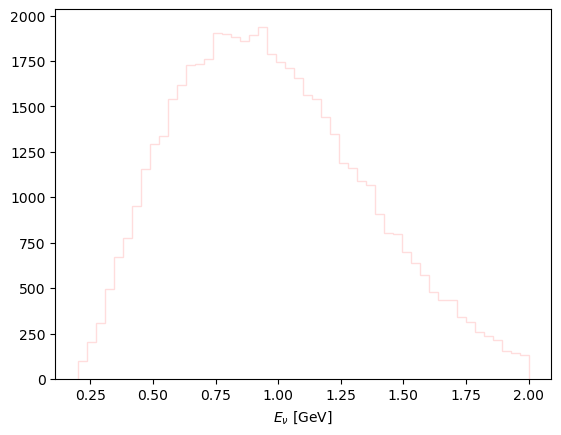

In [21]:
binning = pn.Binning.lin_space(0.2, 2, 50, r"$E_\nu$ [GeV]")
hist = pn.HistFrame(binning)

for ev,cvw in nuevs:
    if sel_cc0pi(ev):
        hist.fill(enu_plep_gev(ev), cvw)

hist.mpl().hist(histtype="step", color="#F002")
plt.show()

For the rest of this demo, we will use the `EventFrame` type for simplicity as we don't need any dataframe functionality or to save things to disk. The `fill` function below can be thought of similarly to `TTree::Draw` in the sense that they execute the histogram filling loop for you, this allows the C++ backend to fill the histogram very quickly.

To show off some more features, we'll also go to 2D.

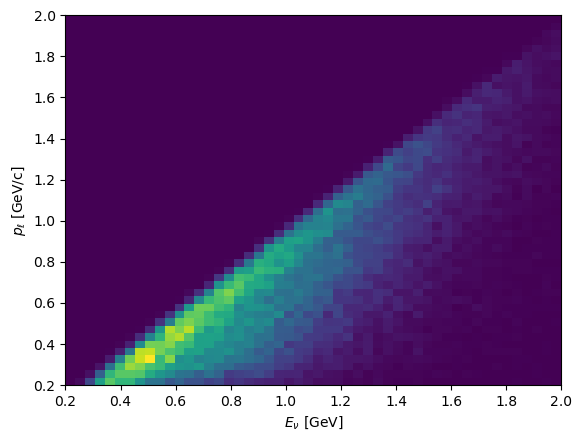

In [22]:
hist = pn.HistFrame(pn.Binning.lin_spaceND([[0.2,2,50],[0.2,2,50]],[r"$E_\nu$ [GeV]",r"$p_\ell$ [GeV/c]"]))
hist.fill(ev_frame, ["enu", "plep"], [pn.HistFrame.fill_column(0), ])
hist.mpl().hist2d()
plt.show()

We can break up the histogram by interaction mode with a variation of the filling helper, `fill_procid_columns_from_EventFrame` which adds a 'column' to the `HistFrame` for every interaction channel encountered. 

You can think of `HistFrame` columns a bit like 'stacks' in a ROOT histogram, but there are no constraints at all on what the data in each column represents, just that each column represents a set of data assigned to every row in the `HistFrame`, where each row corresponds to a single bin. This structure has many uses, a common use beyond keeping track of sub-samples of a total is to represent systematically varied versions of the histogram, either randomly sampled 'universes' or specific variations used to build histfactory-like response functions (or *bin splines* in some experimental neutrino analyser parlance). We will see an example of this later.

In [23]:
hist = pn.HistFrame(pn.Binning.lin_spaceND([[0.2,2,50],[0.2,2,50]],[r"$E_\nu$ [GeV]",r"$p_\ell$ [GeV/c]"]), "total")
hist.fill(ev_frame, ["enu", "plep"], [pn.HistFrame.fill_column("total"), pn.HistFrame.split_by_ProcID()])
print("\n".join([ f"{i}: {x}" for i,x in enumerate(hist.column_info) ] ))

0: Column: name=total
1: Column: name=ProcId:200
2: Column: name=ProcId:300
3: Column: name=ProcId:400
4: Column: name=ProcId:500
5: Column: name=ProcId:600


The interaction process ids are neccessarily generator-specific, but [NuHepMC](https://arxiv.org/pdf/2310.13211#page=11) provides a convention for common blocks of identifiers in E.C.1, *e.g.* 200 is CCQE. It is a requirement of NuHepMC that the process ids are documented in the file itself. We can check back to the GenRunInfo metadata to determine what the different identifers mean.

The `matplotlib` helpers we used on the `HistFrame` before take args to to plot specific columns or to draw to specific axes, by default they plot the first column to the `plt.get_gca()` axis.

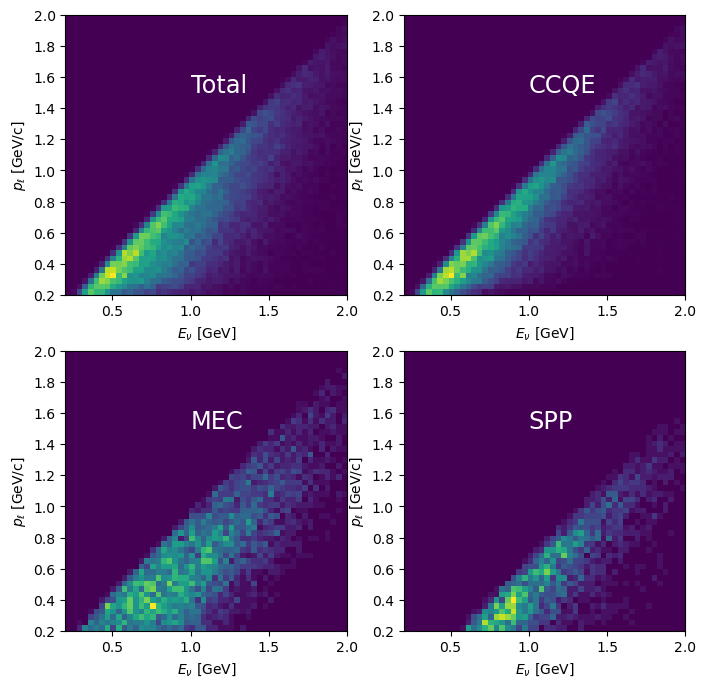

In [24]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))

hist.mpl().hist2d(column="total", plot_axis=ax1)
ax1.text(1, 1.5, "Total", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="ProcId:200", plot_axis=ax2)
ax2.text(1, 1.5, "CCQE", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="ProcId:300", plot_axis=ax3)
ax3.text(1, 1.5, "MEC", c="white", fontsize="xx-large")
hist.mpl().hist2d(column="ProcId:400", plot_axis=ax4)
ax4.text(1, 1.5, "SPP", c="white", fontsize="xx-large")
fig.show()

The NUISANCE3 Histogramming utility also provide slice and projection facilities for working with N-dimensional histograms.

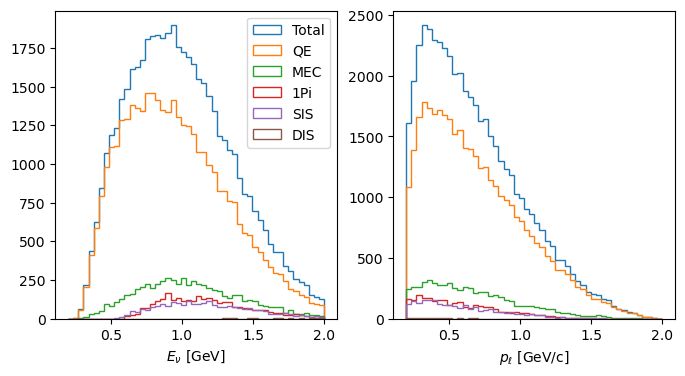

In [25]:
hist_enu = hist.project(0)
hist_pl = hist.project(1)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
hist_enu.mpl().hist_all(plot_axis=ax1, histtype="step", labels=["Total","QE","MEC","1Pi","SIS","DIS"])
hist_pl.mpl().hist_all(plot_axis=ax2, histtype="step")
ax1.legend()
fig.show()

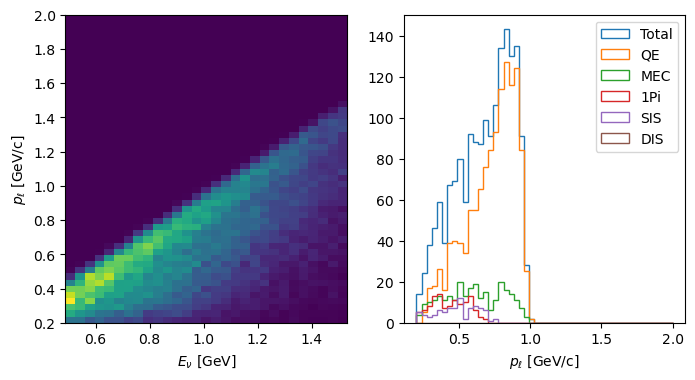

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

#slice a range along the first axis, result is 2D
hist.slice(0, [0.5,1.5]).mpl().hist2d(plot_axis=ax1)
#slice at the bin containing a single value along the first axis, result is 1D
hist.slice(0, 1).mpl().hist_all(plot_axis=ax2, histtype="step", labels=["Total","QE","MEC","1Pi","SIS","DIS"])
ax2.legend()
plt.show()

## A Data Comparison

NUISANCE3 will interface dynamically to HepData for automated data comparisons. At the time of writing the 350+ samples in NUISANCE2 have not been migrated to HepData, so we provide a NUISANCE2 interface, which lets you use some of the measurements from NUISANCE2 in NUISANCE3.

We have not yet discussed scaling an event rate to a cross section. The ability to do this seemlessly in a generator-agnostic way is a core goal of NuHepMC, as a result it is fairly easy to do in NUISANCE. Both `eventinput` instances and `EventFrames` carefully track the sum of weights squared and the reported flux-averaged total cross section. The scale factor to take a weighted-filled histogram to a cross section prediction is simply to scale by the ratio of the two.

Another detail that I will not dwell on much are that there are two types of binned objects, a `HistFrame` and a `BinnedValues`. A `HistFrame` can be filled and tracks the sum of fill weights and the sum of fill weights squared for each bin. A `BinnedValues` is static and has a value and an error associated with each bin. A `HistFrame` can be `finalise`d to a `BinnedValues` and a `BinnedValues` can spawn an empty `HistFrame` ready for filling.

Here, instead of producing a table of *only* selected events, we will add the result of applying the selection as another column, this highlights the power of this approach to broadcast multiple selections and projections over a single input file and perform MC studies on a single dataframe-like object.

In [27]:
rf = pn.RecordFactory()
nuis2 = rf.make_record({"type":"nuisance2"})
MicroBooNE_CC1MuNp_XSec_1DPmu_nu = nuis2.analysis("MicroBooNE_CC1MuNp_XSec_1DPmu_nu")

StatUtils.cxx::GetInvert[l. 1006] : [LOG Sample]:--  : Measurement1D.cxx::FinaliseMeasurement[l. 562] : Finalising Measurement: MicroBooNE_CC1MuNp_XSec_1DPmu_nu
StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : StatUtils.cxx::SetDataErrorFromCov[l. 1244] : StatUtils.cxx::SetDataErrorFromCov[l. 1248] : StatUtils.cxx::SetDataErrorFromCov[l. 1249] : [Record:cri

[ERR WARN  ]: Allowing SVD inverse if matrices are singular, use with extreme caution!
[ERR WARN  ]: Data error does not match covariance error for bin 1 (0.1-0.18)
[ERR WARN  ]: Data error: 5.2855e-38
[ERR WARN  ]: Cov error:  1.32137e-39
[ERR WARN  ]: Data error does not match covariance error for bin 2 (0.18-0.3)
[ERR WARN  ]: Data error: 4.83024e-38
[ERR WARN  ]: Cov error:  1.20756e-39
[ERR WARN  ]: Data error does not match covariance error for bin 3 (0.3-0.48)
[ERR WARN  ]: Data error: 6.60283e-38
[ERR WARN  ]: Cov error:  1.65071e-39
[ERR WARN  ]: Data error does not match covariance error for bin 4 (0.48-0.75)
[ERR WARN  ]: Data error: 4.63694e-38
[ERR WARN  ]: Cov error:  1.15923e-39
[ERR WARN  ]: Data error does not match covariance error for bin 5 (0.75-1.14)
[ERR WARN  ]: Data error: 1.65438e-38
[ERR WARN  ]: Cov error:  4.13596e-40
[ERR WARN  ]: Data error does not match covariance error for bin 6 (1.14-2.5)
[ERR WARN  ]: Data error: 2.02749e-39
[ERR WARN  ]: Cov error:  

In [43]:
ev_frame = pn.EventFrameGen(nuevs)\
            .add_int_column("mbsel", MicroBooNE_CC1MuNp_XSec_1DPmu_nu.get_selection().op) \
            .add_double_column("Pmu", MicroBooNE_CC1MuNp_XSec_1DPmu_nu.get_projections()[0].op)\
            .all()
nuevs_ni = nuevs.norm_info(pn.nhm.FATXUtils.cm2ten38_PerNucleon)
fatx_ptn = nuevs_ni.fatx
sumweights = nuevs_ni.sumweights

In [44]:
print(ev_frame.column_names)
print(ev_frame)

['event.number', 'weight.cv', 'fatx_per_sumw.pb_per_target.estimate', 'fatx_per_sumw.pb_per_nucleon.estimate', 'process.id', 'mbsel', 'Pmu']
 -------------------------------------------------------------------------------------------
 | event.number | weight.cv | fatx_per_su$ | fatx_per_su$ | process.id | mbsel |       Pmu |
 -------------------------------------------------------------------------------------------
 |            0 |         1 |       0.3771 |     0.009427 |        400 |     0 | 3.736e+09 |
 |            1 |         1 |       0.1885 |     0.004714 |        250 |     0 | 3.736e+09 |
 |            2 |         1 |       0.1257 |     0.003142 |        500 |     0 | 3.736e+09 |
 |            3 |         1 |      0.09427 |     0.002357 |        500 |     0 | 3.736e+09 |
 |            4 |         1 |      0.07542 |     0.001885 |        200 |     1 |    0.1714 |
 |            5 |         1 |      0.06285 |     0.001571 |        200 |     0 | 3.736e+09 |
 |            6 |     

In [52]:
print(f"""The average cross section scale factor per event: {fatx_ptn/sumweights} cm^-38/N 
  for a total eventweight of {sumweights}.""")

The average cross section scale factor per event: 9.427258376829043e-06 cm^-38/N 
  for a total eventweight of 100000.0.


When filling the `HistFrame`, we now have to use another method from the family of fill functions, one that takes a column identifier to use as a selection.

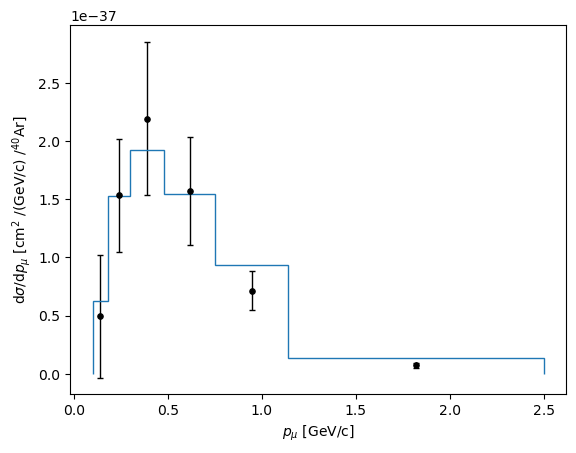

In [70]:
data = MicroBooNE_CC1MuNp_XSec_1DPmu_nu.get_data()[0]

data.mpl().errorbar(marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)

mc = data.make_HistFrame()

mc.fill(ev_frame, ["Pmu"], [ pn.HistFrame.fill_column(0), pn.HistFrame.fill_if("mbsel")])

#required because this analysis is in cm^2 /Ar40 not the nuisance2 default of 1E-38 cm2/N
ana_scale = 1E-38 * 40.0

mcpred = mc.finalise(True).scale(ana_scale * (fatx_ptn/sumweights))

mcpred.mpl().hist(histtype="step")
plt.ylabel(r"d$\sigma$/d$p_{\mu}$ [cm$^{2}$ /(GeV/c) /$^{40}$Ar]")
plt.xlabel(r"$p_{\mu}$ [GeV/c]")
plt.show()

In [ ]:
import os
os.environ["NUISANCE_RECORD_DATABASE"] = os.getcwd()

The tools work on a reference format that allows referencing objects within a record (and sometimes objects within objects). The reference format is below:

```
[<type=hepdata>:][<id>][/<resource[:<qualifier>]>]
```

It might seem weird that *all* parts of the reference are optional, such that `ref = ""` is a valid reference. That is because references are evaluated in a context, which is used to populate defaults for each part of the reference. This means that a reference can be inter- or intra- record, which is very useful.

References are resolved to a local path to referenced object. In the example below we want a local path to the HepData sanbox record, 1713917002.

In [ ]:
%%time 
recordid=1713917002
submission_path, resource_path, refcontext = pn.hpd.get_local_path_to_resource(reftype="hepdata-sandbox", recordid=recordid)
ref = pn.hpd.context_to_ref(**refcontext)
print(f"{ref}\n  -> {resource_path}")

So now we have a local copy, and a path to that local copy, of the reference. If you think it executes a bit slowly, that is because it is downloading and unzipping the HepData record. 

If you run it again, it will still be slow... because it has to check if it has the latest version of the record in the local cache. You can stop it checking by using the version-qualified reference that is returned with the resource path.

In [ ]:
%%time
submission_path, resource_path, refcontext = pn.hpd.get_local_path_to_resource(ref)

Okay, that was a bit detailed, but for automation purposes, it is important that we can programatically fetch and resolve HepData records.

Next we want to query the information in the record. I won't go into as much detail here, but `records` contain `tables` which correspond to measurements, and tables container `qualifiers` which are simple key-value meta-data that we use to store lots of interesting things.

Lets look at the tables that this record holds and any additional resources that are contained in the record.

In [ ]:
table_names = pn.hpd.get_table_names(ref)
pretty_table_names = "\n  ".join(table_names)
print(f"Tables:\n  {pretty_table_names}")

In [ ]:
additional_resources = pn.hpd.get_local_additional_resources(ref)
pretty_additional_resources = "\n  ".join(additional_resources["common"])
print(f"Additional Resources:\n  {pretty_additional_resources}")

The most important file here is `analysis.cxx`, which is a ProSelecta analysis file, lets take a look at it!

In [ ]:
analysis_file = pn.hpd.get_local_path_to_resource(f"{ref}/analysis.cxx")[1]
for line in open(analysis_file):
    print(line.rstrip())

Neat, we can ask ProSelecta to JIT this file and then grab handles to functions out of it so that we can apply selections and projections for this measurement

In [ ]:
import pyProSelecta as pps
pps.load_file(analysis_file)

There are quite a few functions in the analysis file because there are quite a few tables in the record. We need to know which functions correspond to which record, this is where qualifiers come into play!

We're going to make the rest of the code 'table agnostic', but we'll pick just one table as the example, lets do `cross_section-alpha3d`

In [ ]:
def measurement_details(ref, table_name):
    table_file, refcontext = pn.hpd.get_local_path_to_resource(f"{ref}/{table_name}")[1:]

    print(f"Table: {table_name}")
    
    indep_vars = pn.hpd.get_independent_variables(table_file)
    print(f"  Independent_variables: {indep_vars}")
    
    quals = pn.hpd.get_qualifiers(table_file)
    pretty_quals = "\n    ".join([f"{k}: {v}" for k,v in quals.items()])
    print(f"  Qualifiers:\n    {pretty_quals}")

    return indep_vars, quals, refcontext

table_name = "cross_section-alpha3d"
indep_vars, quals, refcontext = measurement_details(ref, table_name)

First, lets check the 'flux'. The `probe_spectrum` qualifier contains a reference to the most appropriate flux file to use for this measurement.

We can convert the HepData-native yaml version of the flux histogram into a NUISANCE `BinnedValues` object and plot it (or convert it to a root file for use with `nuis gen`... see the threads of automation!)

We evaluate the `probe_spectrum` reference in the full context of the record, we can see that in this case, the reference points to another table in the same record, but in general the most appropriate flux prediction could be stored in another record.

In [ ]:
flux_table = pn.hpd.get_table(quals["probe_spectrum"], **refcontext)
ub_flux = pn.convert.HistFrame.from_yaml_str(str(flux_table))
ub_flux.mpl().hist(histtype="step")
plt.show()

Next we need to get handles to the selection and projection functions. The name of the selection function is stored as the value for the `select` qualifier and each independent variable needs one projection function, which is also stored as a qualifier.

In [ ]:
selfunc = pps.select.get(quals["select"])
projfunc = pps.project.get(quals[f"project:{indep_vars[0]}"])

We can then use these to make a data frame containing everything we need to make a prediction of the MC truth for this measurement. For fun, I'm going to include all of the projections in this table.

In [ ]:
ev_frame_gen = pn.EventFrameGen(nuevs).filter(selfunc)

for tbl in table_names:
    tf = pn.hpd.get_local_path_to_resource(f"{ref}/{tbl}")[1]
    iv = pn.hpd.get_independent_variables(tf)
    q = pn.hpd.get_qualifiers(tf)
    if "select" not in q: #only want measurements
        continue
    ev_frame_gen.add_column(f"{iv[0]}", pps.project.get(q[f"project:{iv[0]}"]))
    
ev_frame = ev_frame_gen.all()

In [ ]:
print(ev_frame)

Hopefully it is clear how powerful this is. 

We aren't constrained to filling variables only from the same record, we can include the selections from any number of measurements, whether those measurements are on Argon, in the microboone flux, it doesn't matter. The dataframe structure allows rapid prototyping and development of MC studies towards new measurements.

Without further ado, lets make a comparison, the details of this comparison are more involved than the NUISANCE2 example earlier as we need to apply the smearing matrix before 'finalising' the HistFrame. Because HistFrames are just backed by Eigen 2D arrays, which are exposed as numpy objects, this is trivial to do, as shown below.

In [ ]:
def make_comp(ref, table_name):
    indep_vars, quals, refcontext = measurement_details(ref, table_name)

    xs_table = pn.hpd.get_table(table_name, **refcontext)
    xs_data = pn.convert.HistFrame.from_yaml_str(str(xs_table))
    
    xs_data.mpl().errorbar(marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)

    # fatx is in pb/A, but need cm^-38 /A
    sf = ev_frame.norm_info().fatx_per_sumweights() * (1E2)
    
    smearing_table = pn.hpd.get_table(quals["smearing"], **refcontext)
    smearing_mat = pn.convert.Covariance.from_yaml_str(str(smearing_table))
    
    xs_mc = xs_data.make_HistFrame()
    xs_mc.fill_from_EventFrame(ev_frame, [indep_vars[0],])
    
    xs_mc.sumweights = smearing_mat.T @ (xs_mc.sumweights * sf)
    xs_mc.variances = (smearing_mat @ smearing_mat) @ xs_mc.variances * (sf**2)
    
    xs_mc_pred = xs_mc.finalise()
    xs_mc_pred.mpl().hist(histtype="step", label="NuWro", errorband_color="#F003", color="red")

    plt.ylabel(r"$\frac{d\sigma}{d\alpha_{3D}} 10^{-38}$ cm$^{2}$ /degrees /Ar")
    plt.xlabel(r"$\alpha_{3D}$ [degrees]")
    plt.legend()

make_comp(ref, table_name)
plt.show()

The thing to note here is that nothing in the making of the above plot is specialised other than by the name of the measurement that you want to compare to...

In [ ]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))

plt.sca(ax1)
make_comp(ref, "cross_section-phi3d")
plt.sca(ax2)
make_comp(ref, "cross_section-pn_para")
plt.sca(ax3)
make_comp(ref, "cross_section-pn_perp")
plt.sca(ax4)
make_comp(ref, "cross_section-pn")
plt.show()

In [ ]:
%%bash

# make sure NUISANCE2 is the NUISANCE in the path
export PATH=/opt/nuisance/git_master/bin:${PATH}

if [ ! -e NuWro.numu.BNB_uBooNE.100k.v1.root ]; then
    mkdir -p nuwrogenv1
    cd nuwrogenv1
    nuis gen NuWro -E MicroBooNE -n 100000 -t Ar -P numu -o NuWro.numu.BNB_uBooNE.100k.v1.root -p MEC_cm_direction=1 &> /dev/null
    cp NuWro.numu.BNB_uBooNE.100k.v1.root ../
    cd ../
    rm -r nuwrogenv1
fi

if [ ! -e NuWro.numu.BNB_uBooNE.100k.v2.root ]; then
    mkdir -p nuwrogenv2
    cd nuwrogenv2
    nuis gen NuWro -E MicroBooNE -n 100000 -t Ar -P numu -o NuWro.numu.BNB_uBooNE.100k.v2.root -p MEC_cm_direction=-1 &> /dev/null
    cp NuWro.numu.BNB_uBooNE.100k.v2.root ../
    cd ../
    rm -r nuwrogenv2
fi

In [ ]:
nuevsv1 = pn.EventSource("NuWro.numu.BNB_uBooNE.100k.v1.root")
nuevsv2 = pn.EventSource("NuWro.numu.BNB_uBooNE.100k.v2.root")

ev_framev1 = pn.EventFrameGen(nuevsv1)\
             .filter(selfunc) \
             .add_column(indep_vars[0], projfunc).all()
ev_framev2 = pn.EventFrameGen(nuevsv2)\
             .filter(selfunc) \
             .add_column(indep_vars[0], projfunc).all()

indep_vars, quals, refcontext = measurement_details(ref, table_name)

xs_table = pn.hpd.get_table(table_name, **refcontext)
xs_data = pn.convert.HistFrame.from_yaml_str(str(xs_table))

# fatx is in pb/A, but need cm^-38 /A
sf = ev_frame.norm_info().fatx_per_sumweights() * (1E2)

smearing_table = pn.hpd.get_table(quals["smearing"], **refcontext)
smearing_mat = pn.convert.Covariance.from_yaml_str(str(smearing_table))

xs_mc = xs_data.make_HistFrame()
xs_mc.fill_from_EventFrame(ev_frame, [indep_vars[0],])

xs_mc.sumweights = smearing_mat.T @ (xs_mc.sumweights * sf)
xs_mc.variances = (smearing_mat @ smearing_mat) @ xs_mc.variances * (sf**2)

xs_mc_pred = xs_mc.finalise()

xs_mcv1 = xs_data.make_HistFrame()
xs_mcv2 = xs_data.make_HistFrame()
xs_mcv1.fill_from_EventFrame(ev_framev1, [indep_vars[0], ])
xs_mcv2.fill_from_EventFrame(ev_framev2, [indep_vars[0], ])

xs_mcv1.sumweights = smearing_mat.T @ (xs_mcv1.sumweights * sf)
xs_mcv1.variances = (smearing_mat @ smearing_mat) @ xs_mcv1.variances * (sf**2)

xs_mcv1_pred = xs_mcv1.finalise()

xs_mcv2.sumweights = smearing_mat.T @ (xs_mcv2.sumweights * sf)
xs_mcv2.variances = (smearing_mat @ smearing_mat) @ xs_mcv2.variances * (sf**2)

xs_mcv2_pred = xs_mcv2.finalise()


In [ ]:
xs_mc_pred.mpl().hist(histtype="step", label="NuWro", errorband_color="#00F3", color="red")

xs_mcv1_pred.mpl().hist(histtype="step", label="NuWro, MEC_cm_direction=1", errorband_color="#0F03", color="green")

xs_mcv2_pred.mpl().hist(histtype="step", label="NuWro, MEC_cm_direction=-1", errorband_color="#00F3", color="blue")

xs_data.mpl().errorbar(marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)

plt.ylabel(r"$\frac{d\sigma}{d\alpha_{3D}} 10^{-38}$ cm$^{2}$ /degrees /Ar")
plt.xlabel(r"$\alpha_{3D}$ [degrees]")
plt.legend()
plt.show()

## ReWeighted

For ReWeighting, we need some NEUT (or GENIE) events

In [ ]:
%%bash

# make sure NUISANCE2 is the NUISANCE in the path
export PATH=/opt/nuisance/git_master/bin:${PATH}

if [ ! -e NEUT.numu.BNB_uBooNE.100k.root ]; then
    mkdir -p neutgen
    cd neutgen
    nuis gen NEUT -E MicroBooNE -n 100000 -t Ar -P numu -o NEUT.numu.BNB_uBooNE.100k.root -x NEUT-MDLQE=2 &> /dev/null
    cp NEUT.numu.BNB_uBooNE.100k.root ../
    cp *.card ../
    cd ../
    rm -r neutgen
fi

In [ ]:
nutevs = pn.EventSource("NEUT.numu.BNB_uBooNE.100k.root")
if not nutevs:
    print("failed to read NEUT.numu.BNB_uBooNE.100k.root")

In [ ]:
%env NIWG_ROOT=/opt/t2kreweight/24.05.02

In [ ]:
wf = pn.WeightCalcFactory()
t2krw = wf.make(nutevs, {"plugin_name":"T2KReWeight", "neut_cardname": "neutvect.numu.numu.BNB_uBooNE_numu_flux_2019.11383.card"})

In [ ]:
def wghtsp(ev,maqe):
    def wghts(ev):
        t2krw.set_parameters({"MaCCQE": 1.4})
    resp = np.array([0,0])
    t2krw.set_parameters({"MaCCQE": 1.4})
    resp[0] = t2krw.calc_weight(ev)
    t2krw.set_parameters({"MaCCQE": 1.0})
    resp[1] = t2krw.calc_weight(ev)
    return resp

In [ ]:
nevf = pn.EventFrameGen(nutevs)\
  .filter(selfunc) \
  .add_column("alpha3d", projfunc) \
  .add_double_columns(["MaCCQE=1.4","MaCCQE=1.0"], wghts) \
  .all()

In [ ]:
print(fg)